# 02 Production_Electric_Active Energy (kWh)


In [1]:
import pandas as pd

In [2]:
cd ..

c:\Users\Usuario\OneDrive\Documents\IE\3. Trimestre\Venture Lab & Capstone\Capstone\Tech side\vl_optimizer


## Definition of the constrain equation

This model allows for a comprehensive understanding of how various operational factors, including the number of workers, affect energy consumption in a textile production plant, ensuring efficient energy management without impacting the core production processes.

**Production_Electric_Active Energy =k⋅power_transport_vehicles + f1​⋅production_schedule + f2​⋅maintenance_status + f3​⋅volume_production_waste + f4​⋅number_of_workers**

- **Production_Electric_Active Energy** = Electricity consumption of the factory in a specific 15-minute slot.

- **power_transport_vehicles**= Power allocated to charging transport vehicles - Controllable. 

Manage when and how much power is used for charging vehicles, optimizing energy usage without impacting production operations.
- **production_schedule**= 
Production Schedule - Given. 

This reflects the operational capacity utilization, influencing energy needs based on how much of the plant’s machinery is in use.
- **maintenance_status** =
Machine Maintenance Status - Given. 

Well-maintained machines operate more efficiently, using less energy. Poor maintenance can lead to increased energy consumption.
- **volume_production_waste** =
Volume of Production Waste - Given. 

Impacts energy consumption through waste management processes.
- **number_of_workers** =
Number of Workers - Given. 

Influences how efficiently machines are operated and supervised, affecting the overall energy use.
- **k, f1, f2, f3, f4** =
Coefficients that represent the impact of each factor on energy consumption.

In [3]:
df = pd.read_csv('data/processed_data/industrial_sites_processed/2024-07-06T21-45-14_industrial_site2_processed.csv')

In [4]:
df.columns

Index(['Time', '02 Production_Electric_Active Energy (kWh)',
       '02 Production_Electric_Active Power (kW)',
       '02 Production_Electric_Apparent Power (kVa)',
       '02 Production_Electric_Power Factor (real)',
       '03 Chiller Group_Electric_Active Energy (kWh)',
       '03 Chiller Group_Electric_Active Power (kW)',
       '03 Chiller Group_Electric_Apparent Power (kVa)',
       '03 Chiller Group_Electric_Power Factor (real)',
       '04 UTA_Electric_Active Energy (kWh)',
       '04 UTA_Electric_Active Power (kW)',
       '04 UTA_Electric_Apparent Power (kVa)',
       '04 UTA_Electric_Power Factor (real)',
       '05 Compressors_Electric_Active Energy (kWh)',
       '05 Compressors_Electric_Active Power (kW)',
       '05 Compressors_Electric_Apparent Power (kVa)',
       '05 Compressors_Electric_Power Factor (real)',
       '06 Offices_Electric_Active Energy (kWh)',
       '06 Offices_Electric_Active Power (kW)',
       '06 Offices_Electric_Apparent Power (kVa)',
       '06 

In [5]:
df['Time']

0       2022-07-01 00:00:00
1       2022-07-01 01:00:00
2       2022-07-01 02:00:00
3       2022-07-01 03:00:00
4       2022-07-01 04:00:00
               ...         
8755    2023-06-30 19:00:00
8756    2023-06-30 20:00:00
8757    2023-06-30 21:00:00
8758    2023-06-30 22:00:00
8759    2023-06-30 23:00:00
Name: Time, Length: 8760, dtype: object

In [6]:
production_target = (df['02 Production_Electric_Active Energy (kWh)']).dropna()
production_target.to_csv('data/target_variables/target_production.csv', index=False)

## Other factors to include in the constrain equation

Based on the insights from the total consumption data and the nature of each variable, we can refine the boundaries to more accurately reflect the operational reality:

1. **power_transport_vehicles**: Should scale with energy use but within a realistic maximum limit.
2. **production_schedule**: Directly correlates with energy use, scaling between idle to full capacity.
3. **maintenance_status**: Might not directly scale with energy use but should represent a range from poor to excellent.
4. **volume_production_waste**: Could increase with higher production volumes (and thus higher energy use) but should have a maximum cap.
5. **number_of_workers**: Should scale with the production demands reflected by energy consumption.

We will use the percentile distribution of energy consumption to dynamically adjust the maximum limits for variables such as the number of workers and production schedule, which are more directly influenced by the level of activity in the plant.

Let’s start by analyzing the total energy consumption to inform these decisions.

Here are some key statistics from the total energy consumption data:

In [7]:
# Calculating statistical details for the total energy consumption data
production_stats = df['02 Production_Electric_Active Energy (kWh)'].describe()
production_stats

count    8760.000000
mean      106.179921
std       107.453514
min         0.000000
25%         4.808392
50%        94.653716
75%       142.750000
max       458.000000
Name: 02 Production_Electric_Active Energy (kWh), dtype: float64

Using these insights, let's redefine the boundaries for each variable:

1. **power_transport_vehicles**:
   - **Minimum:** 0 kW
   - **Maximum:** 200 kW (assuming peak needs for vehicle charging during the highest energy consumption)

2. **production_schedule**:
   - **Minimum:** 0 (idle)
   - **Maximum:** 100 (full capacity, scaled directly with energy usage)

3. **maintenance_status**:
   - **Minimum:** 0 (poor maintenance)
   - **Maximum:** 100 (excellent maintenance, not directly tied to energy consumption but essential for operational efficiency)

4. **volume_production_waste**:
   - **Minimum:** 0 tons
   - **Maximum:** 50 tons (assuming waste production scales up with higher production volumes)

5. **number_of_workers**:
   - **Minimum:** 0 (no workers during idle periods)
   - **Maximum:** 500 (full staffing during peak production times)

For variables like **production_schedule** and **number_of_workers**, which should scale with energy consumption, we could set dynamic maximums based on the percentiles of energy consumption:

- Use the 75th percentile as a typical upper limit during high production times.
- Scale the maximum values of these variables proportionally to how close the energy consumption is to the maximum observed value.

## Synthesized dataset

In [8]:
import pandas as pd
import numpy as np

# Number of samples is equal to the number of entries in the consumption data
n_samples = len(production_target)

# Initialize the random seed for reproducibility
np.random.seed(42)

# Define dynamic ranges based on energy consumption percentiles
max_energy = df['02 Production_Electric_Active Energy (kWh)'].max()
scale_factor = df['02 Production_Electric_Active Energy (kWh)'] / max_energy

# Define a controlled noise level relative to the scale of each feature
noise_level = 0.15  # Noise level as a percentage of feature's max value

# Generating data within the defined boundaries
data = {
    'power_transport_vehicles': np.maximum(0, 200 * scale_factor + np.random.normal(0, 200 * noise_level, n_samples)),
    'production_schedule': np.maximum(0, np.round(100 * scale_factor + np.random.normal(0, 100 * noise_level, n_samples))),
    'maintenance_status': np.maximum(0, 100 * scale_factor + np.random.normal(0, 100 * noise_level, n_samples)),
    'volume_production_waste': np.maximum(0, 50 * scale_factor + np.random.normal(0, 50 * noise_level, n_samples)),
    'number_of_workers': np.maximum(0, np.round(150 * scale_factor + np.random.normal(0, 500 * noise_level, n_samples)))
}

df_simulated = pd.DataFrame(data)

# Save the generated data to a new CSV
output_path = 'data/synthesized_data/production_synthesized.csv'
df_simulated.to_csv(output_path, index=False)

output_path


'data/synthesized_data/production_synthesized.csv'

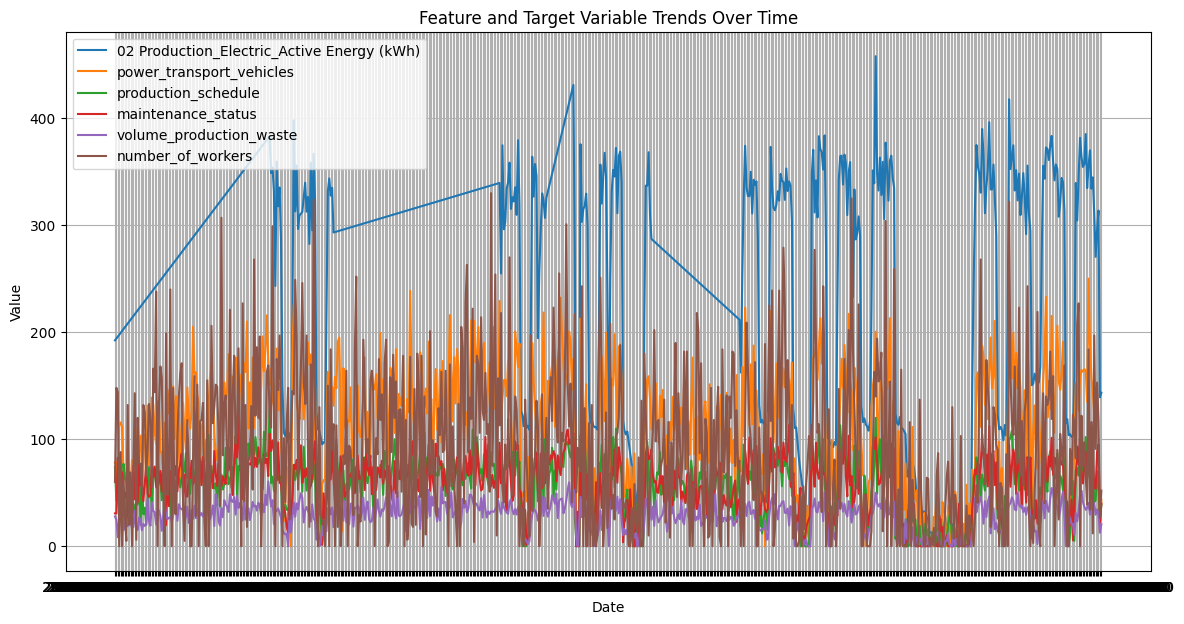

In [9]:
import matplotlib.pyplot as plt

# Combine target and features into one DataFrame
df_combined = pd.concat([df['Time'], df['02 Production_Electric_Active Energy (kWh)'], df_simulated], axis=1)
df_combined.set_index('Time', inplace=True)

# Define the time period you want to plot
start_date = '2023-06-01'
end_date = '2023-06-30'

# Slice the DataFrame to the desired period
df_period = df_combined.loc[start_date:end_date]

# Plotting
plt.figure(figsize=(14, 7))
for column in df_period.columns:
    plt.plot(df_period.index, df_period[column], label=column)
plt.legend()
plt.title('Feature and Target Variable Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


## Get cofficients

In [10]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump

# Define the target
target = production_target

# Define the features
features = df_simulated.columns

# Split the data into features (X) and target (y)
X = df_simulated
y = target

# Initialize the linear regression model
model = LinearRegression()

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_mse = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
cv_results_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Fit the model on the entire dataset
model.fit(X, y)

# Get the intercept and coefficients
intercept = model.intercept_
coefficients = model.coef_

# Save the trained model to a file
model_params = {
    'intercept': intercept,
    'coefficients': coefficients,
    'features': features
}
model_filename = 'equation_modeling/models/production_consumption_model.joblib'
dump(model_params, model_filename)

# Calculate and print performance metrics
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error (Cross-Validation): {-cv_results_mse.mean()}')
print(f'Standard Deviation (Cross-Validation): {cv_results_mse.std()}')
print(f'R^2 Score (Cross-Validation): {cv_results_r2.mean()}')
print(f'Overall R^2 Score: {r2}')

# Optional: Print the coefficients of the model
coefficients_df = pd.DataFrame(coefficients, features, columns=['Coefficient'])
print(f'Intercept: {intercept}')
print(coefficients_df)


Mean Squared Error (Cross-Validation): 966.8564932288076
Standard Deviation (Cross-Validation): 34.55269340334083
R^2 Score (Cross-Validation): 0.9161031058868219
Overall R^2 Score: 0.9163959925707674
Intercept: -12.129164587244432
                          Coefficient
power_transport_vehicles     0.549692
production_schedule          1.162542
maintenance_status           1.164858
volume_production_waste      2.139640
number_of_workers            0.076697
